### Download image with wget command

In [31]:
# get image.
!wget https://miro.medium.com/max/1024/1*lKz4iFqzz2vt04k21YWuUw.jpeg -O sample.jpg

--2020-04-27 18:05:36--  https://miro.medium.com/max/1024/1*lKz4iFqzz2vt04k21YWuUw.jpeg
Resolving miro.medium.com (miro.medium.com)... 104.16.119.145, 104.16.121.145, 104.16.120.145, ...
Connecting to miro.medium.com (miro.medium.com)|104.16.119.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64566 (63K) [image/jpeg]
Saving to: ‘sample.jpg’

sample.jpg          100%[===================>]  63.05K  --.-KB/s    in 0.007s  

2020-04-27 18:05:36 (8.34 MB/s) - ‘sample.jpg’ saved [64566/64566]



### Install python libraries (assume you are running Python 3.x)

In [32]:
! pip install -r requirements.txt

### Run code via command line interface

In [33]:
!python utils.py sample.jpg out.yml

### Show results

In [57]:
import numpy as np
import imageio
import json
import matplotlib.pyplot as plt
%matplotlib inline

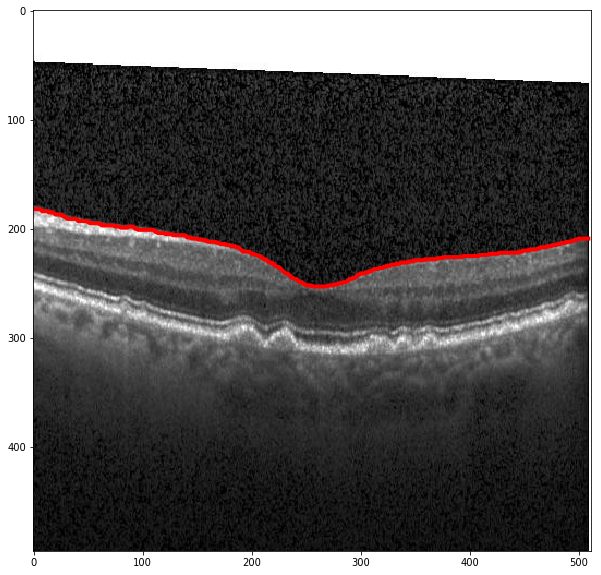

In [58]:
input_image = imageio.imread('sample.jpg')
with open('out.yml','r') as f:
    coord = json.loads(f.read())

plt.figure(figsize=(10,15))
plt.imshow(input_image)
# plot axis oddness when used with imshow
plt.plot(coord['y'],coord['x'],color='red',linewidth=4)

### Alternatively, run code block in "development mode"

In [59]:
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# load module
from utils import segment_layer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
x0,y0,i0 = segment_layer(input_image[:,:,0])

In [61]:
ulim=250
llim=350
x1,y1,i1 = segment_layer(input_image[:,:,0],dark2bright=False,ulim=ulim,llim=llim)

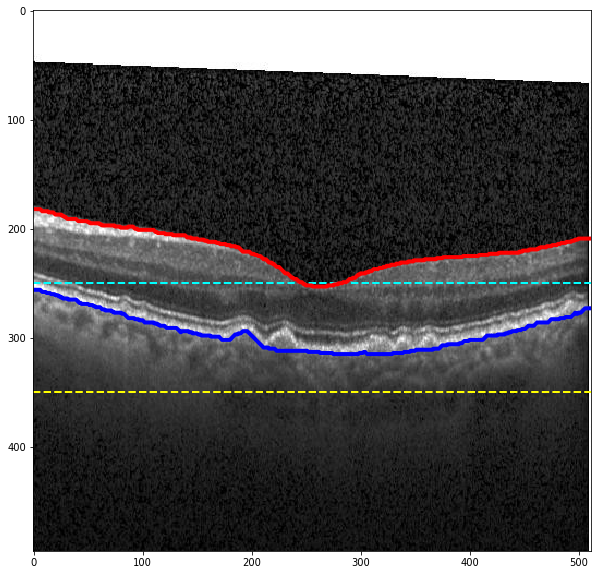

In [62]:
plt.figure(figsize=(10,15))
plt.imshow(input_image)
plt.axhline(ulim,linewidth=2,color='cyan',linestyle='--')
plt.axhline(llim,linewidth=2,color='yellow',linestyle='--')

plt.plot(y0,x0,color='red',linewidth=4)
plt.plot(y1,x1,color='blue',linewidth=4)

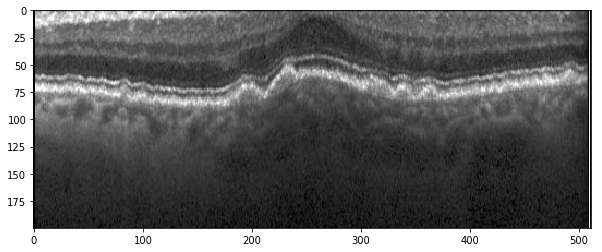

In [65]:
# read
input_image = imageio.imread('sample.jpg')
# get 1 channel
org_image = input_image[:,:,0]
# segment
x0,y0,i0 = segment_layer(org_image)

# shift per a scan
shifted_image = np.zeros(org_image.shape)
for y in range(shifted_image.shape[1]):
    if y in y0:
        i = np.where(y1==y)[0][0]
        shifted_image[:,y] = np.roll(org_image[:,y],-1*x0[i])
        
# viz
plt.figure(figsize=(10,15))
plt.imshow(shifted_image[:200,:],cmap='gray')